# Importante: antes de executar esse notebook execute o mortalidade.ipynb para gerar os dados de mortalidade

# Projeto de Ciência de dados:
## Desenvolvimento de um indíce de vulnerabilidade das cidades brasileiras em relação ao covid- 19

## OBSERVAÇÃO: Caso esteja no linux, tire o encoding = "ISO-8859-1" do lado das leituras dos datasets.

### Importando as bibliotecas a serem utilizadas
O primeiro passo será importar as bibliotecas a serem utilizadas

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as py
import seaborn as sb

# LOF Algorithm
from sklearn.neighbors import LocalOutlierFactor

## Normalização dos dados
from sklearn.preprocessing import MaxAbsScaler

## K-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


### Lendo o primeiro dataset: Dados do Covid-19

Primeiro dataset a ser lido é o dos dados sobre o COVID-19 (casos, mortes...)
Após realizar a leitura dele, utilizando o encoding "ISO-8859-1" devido aos caracteres e formato dos dados,
realizamos a redução do dataset, mantendo apenas as colunas que são relavantes para a análise.

In [2]:
df_covid = pd.read_csv('dataset-covid19.csv', encoding = "ISO-8859-1")
df_covid = df_covid[['state', 'city', 'place_type', 'city_ibge_code', 'estimated_population']]

### Filtrando apenas para dados referentes a cidades

Nessa parte, filtramos para armazenar apenas os dados que fazem referência a cidades (tenham seu place_type igual a city).
Após isso, realizamos a contagem para ver quantos dados nulos temos no dataset resultante


In [3]:
df_covid = df_covid[df_covid.place_type == 'city'] ## Filtra para pegar apenas dados de cidades
df_covid.isnull().sum() ## Realiza a contagem de quantos valores nulos temos

state                    0
city                     0
place_type               0
city_ibge_code          19
estimated_population    19
dtype: int64

### Ajustes do Dataset

Ao observarmos quais dados estão faltantes, observamos que o city desses casos apresentam valores iguais a Importados/Indefinidos. Portanto, retiramos do dataset esses dados.

Após, realizamos a conversão da coluna city_ibge_code, para que em vez de ser do tipo string, seja do tipo inteiro.

Por fim, renomeamos o nome de duas colunas, para facilitar o uso posterior: De state para UF, e de city para Nome do município.

In [4]:
df_covid = df_covid[df_covid.city != 'Importados/Indefinidos'] ## Remoção das linhas em branco

df_covid['city_ibge_code'] = df_covid['city_ibge_code'].astype(int) ## Conversão da coluna para inteiro

df_covid= df_covid.rename(columns={'state': 'UF'}) ## Trocando o nome de state para UF
df_covid= df_covid.rename(columns={'city': 'Nome do município'}) ## Trocando o nome de city para Nome do município
df_covid

,UF,Nome do município,place_type,city_ibge_code,estimated_population
0,AC,Acrelândia,city,1200013,15490.0
1,AC,Assis Brasil,city,1200054,7534.0
2,AC,Brasiléia,city,1200104,26702.0
3,AC,Bujari,city,1200138,10420.0
4,AC,Capixaba,city,1200179,12008.0
...,...,...,...,...,...
5610,RN,Várzea,city,2414704,5515.0
5611,RN,Venha-Ver,city,2414753,4205.0
5612,RN,Vera Cruz,city,2414803,12637.0
5613,RN,Viçosa,city,2414902,1725.0


### Lendo o segundo Dataset: Dados de internações
O segundo dataset é sobre os dados de internações nas unidades hospitalares. Novamente usamos o enconding ISO-8859-1.

Após, retiramos as linhas que contem dados faltantes e renomamos duas colunas (estadoSigla para UF, e municipio para Nome do município).

Por fim, criamos uma nova coluna que é a soma da UF com o Nome do munícipio. Essa coluna será utilizada para a agragação posterior dos dados de uma mesma cidade.

In [5]:
df_inter = pd.read_csv('dataset-inter.csv',  encoding = "ISO-8859-1") ## Lê o dataset

df_inter = df_inter.dropna() ## Remove os dados nulos

df_inter= df_inter.rename(columns={'estadoSigla': 'UF'}) ## Renomeia a coluna estadoSigla para UF
df_inter= df_inter.rename(columns={'municipio': 'Nome do município'}) ## Renomeia a coluna municipio para Nome do município

df_inter['UF-City'] = df_inter['UF'] + df_inter['Nome do município']  ##Cria uma nova coluna para diferencias cada cidade
df_inter.head(95)

,estado,UF,Nome do município,cnes,nomeCnes,dataNotificacaoOcupacao,ofertaRespiradores,ofertaHospCli,ofertaHospUti,ofertaSRAGCli,ofertaSRAGUti,ocupHospCli,ocupHospUti,ocupSRAGCli,ocupSRAGUti,altas,obitos,ocupacaoInformada,algumaOcupacaoInformada,UF-City
0,Amazonas,AM,Humaitá,2017016,HOSPITAL DR LUIZA DA CONCEICAO FERNANDES,2020-11-26T04:00:11.195Z,1.0,46.0,0.0,0.0,0.0,0.0,0.0,5.0,0,2.0,0.0,True,True,AMHumaitá
1,Pará,PA,Belém,2333031,HOSPITAL DE CLINICAS GASPAR VIANA,2020-11-24T03:00:00.000Z,73.0,209.0,30.0,0.0,0.0,201.0,35.0,19.0,6,4.0,0.0,True,True,PABelém
2,Pernambuco,PE,Sertânia,2712016,HOSPITAL MARIA ALICE GOMES LAFAYETTE,2020-11-27T03:00:19.869Z,0.0,54.0,0.0,18.0,0.0,6.0,0.0,4.0,0,0.0,0.0,True,True,PESertânia
3,Bahia,BA,Bom Jesus da Lapa,4022718,HOSPITAL MUNICIPAL CARMELA DUTRA,2020-11-26T03:00:20.391Z,1.0,71.0,0.0,8.0,0.0,39.0,0.0,4.0,0,0.0,0.0,True,True,BABom Jesus da Lapa
4,Pará,PA,Marabá,0116335,HOSPITAL DE CAMPANHA COVID 19 MARABA,2020-11-26T03:00:19.985Z,0.0,80.0,0.0,89.0,31.0,0.0,0.0,3.0,0,0.0,0.0,True,True,PAMarabá
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Rio de Janeiro,RJ,Rio de Janeiro,9614133,INTERMEDICA,2020-06-01T12:15:25.343Z,0.0,55.0,18.0,0.0,0.0,30.0,10.0,2.0,1,0.0,0.0,True,True,RJRio de Janeiro
96,Paraná,PR,Curitiba,9907939,UNIDADE CUIDADOS CONTINUADOS INTEGRADOS SANTA ...,2020-05-15T00:00:00.000Z,0.0,50.0,0.0,0.0,0.0,3.0,0.0,0.0,0,0.0,0.0,True,True,PRCuritiba
97,Paraná,PR,Corbélia,0105724,HOSPITAL DE CAMPANHA ECLEIA WOLF,2020-05-26T03:00:00.000Z,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,0.0,True,True,PRCorbélia
98,Bahia,BA,Salvador,0003859,HOSPITAL GERAL ROBERTO SANTOS,2020-05-29T15:08:11.579Z,80.0,725.0,112.0,0.0,0.0,137.0,76.0,7.0,14,0.0,1.0,True,True,BASalvador


### Tratamento dos dados de intenação

Como uma cidade pode ter muitos hospitais, optamos por agrupar todos os dados que se referem a uma mesma cidade.
Para tal, utilizamos um groupby usando a coluna criada anteriormente (UF-city), somando todos os dados.

Criamos duas novas colunas, que se referem as taxas de ocupação dos leitos disponíveis para a SRAG, tanto uti como cli.
Como a oferta pode ser zero, a divisão resultaria em infinito. Para corrigir isso, substituimos todos os valores que foram
infinito (positivo ou negativo) por 0.

In [6]:
## Realiza o groupby para unificar os dados de uma mesma cidade
df_inter = df_inter.groupby([df_inter['UF-City'], df_inter['UF'], df_inter['Nome do município']]).sum()
df_inter = df_inter.reset_index()

## Cria as duas novas colunas da taxa de ocupação
df_inter["taxa ocupado SRAG uti"] = df_inter["ocupSRAGUti"] / df_inter["ofertaSRAGUti"]
df_inter["taxa ocupado SRAG cli"] = df_inter["ocupSRAGCli"] / df_inter["ofertaSRAGCli"]


df_pop_estimada = df_covid[['UF', 'Nome do município', 'estimated_population']]
df_inter = pd.merge(df_inter,df_pop_estimada, on=["Nome do município", "UF"])


## Devemos normalizar a ocupação do hospital pela quantidade ocupada

df_inter['ocupHospCli'] = df_inter['ocupHospCli'] / df_inter['ofertaHospCli'] 
df_inter['ocupHospUti'] = df_inter['ocupHospUti'] / df_inter['ofertaHospUti'] 
df_inter['ocupSRAGCli'] = df_inter['ocupSRAGCli'] / df_inter['ofertaSRAGCli'] 
df_inter['ocupSRAGUti'] = df_inter['ocupSRAGUti'] / df_inter['ofertaSRAGUti'] 


## Devemos normalizar o número de respitadores e vagas ofertadas pela popualação da cidade

df_inter['ofertaRespiradores'] = df_inter['ofertaRespiradores'] / df_inter['estimated_population']
df_inter['ofertaHospCli'] = df_inter['ofertaHospCli'] / df_inter['estimated_population'] 
df_inter['ofertaHospUti'] = df_inter['ofertaHospUti'] / df_inter['estimated_population'] 
df_inter['ofertaSRAGCli'] = df_inter['ofertaSRAGCli'] / df_inter['estimated_population'] 
df_inter['ofertaSRAGUti'] = df_inter['ofertaSRAGUti'] / df_inter['estimated_population'] 




##Identifica os extremos (infinitos) e substitui por 0
df_inter[df_inter==np.inf]  = np.nan
df_inter[df_inter== -np.inf] = np.nan
df_inter["taxa ocupado SRAG uti"].fillna(0, inplace=True)
df_inter["taxa ocupado SRAG cli"].fillna(0, inplace=True)

df_inter["ocupHospCli"].fillna(0, inplace=True)
df_inter["ocupHospUti"].fillna(0, inplace=True)
df_inter["ocupSRAGCli"].fillna(0, inplace=True)
df_inter["ocupSRAGUti"].fillna(0, inplace=True)


df_inter


,UF-City,UF,Nome do município,ofertaRespiradores,ofertaHospCli,ofertaHospUti,ofertaSRAGCli,ofertaSRAGUti,ocupHospCli,ocupHospUti,ocupSRAGCli,ocupSRAGUti,altas,obitos,ocupacaoInformada,algumaOcupacaoInformada,taxa ocupado SRAG uti,taxa ocupado SRAG cli,estimated_population
0,ACAcrelândia,AC,Acrelândia,0.000000,0.001033,0.000000,0.000258,0.000000,0.000000,0.000000,0.750000,0.00000,0.0,0.0,1.0,1.0,0.00000,0.750000,15490.0
1,ACAssis Brasil,AC,Assis Brasil,0.000000,0.001593,0.000000,0.000265,0.000000,0.000000,0.000000,0.500000,0.00000,60.0,8.0,1.0,1.0,0.00000,0.500000,7534.0
2,ACCruzeiro do Sul,AC,Cruzeiro do Sul,0.000067,0.001504,0.000090,0.000483,0.000112,0.492537,0.375000,0.511628,0.50000,1.0,0.0,2.0,2.0,0.50000,0.511628,89072.0
3,ACRio Branco,AC,Rio Branco,0.000155,0.001120,0.000058,0.000370,0.000097,0.397408,0.666667,0.745098,0.90000,14.0,2.0,4.0,4.0,0.90000,0.745098,413418.0
4,ALArapiraca,AL,Arapiraca,0.000150,0.001334,0.000099,0.000442,0.000137,0.225080,1.173913,0.291262,0.40625,5.0,1.0,3.0,3.0,0.40625,0.291262,233047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,TOPalmas,TO,Palmas,0.000313,0.002896,0.000225,0.000082,0.000065,0.664036,1.710145,0.880000,1.50000,2.0,1.0,9.0,9.0,1.50000,0.880000,306296.0
1951,TOParaíso do Tocantins,TO,Paraíso do Tocantins,0.000096,0.001715,0.000000,0.000674,0.000000,0.292135,0.000000,0.057143,0.00000,1.0,0.0,1.0,1.0,0.00000,0.057143,51891.0
1952,TOPedro Afonso,TO,Pedro Afonso,0.000000,0.002323,0.000000,0.000581,0.000000,0.218750,0.000000,0.250000,0.00000,1.0,0.0,1.0,1.0,0.00000,0.250000,13773.0
1953,TOPorto Nacional,TO,Porto Nacional,0.000094,0.002832,0.000000,0.000356,0.000000,0.337748,0.000000,0.105263,0.00000,3.0,0.0,2.0,2.0,0.00000,0.105263,53316.0


In [7]:
df_inter["ocupSRAGUti"].corr(df_inter["ocupHospUti"])

0.5121772251242211

In [8]:
df_inter["ocupSRAGUti"].corr(df_inter["ocupHospUti"])

0.5121772251242211

### Reduzindo a dimensionalidade 

Por se tratarem de muitos dados relevantes correspondentes aos hospitais, buscamos diminuir a dimensionalidade deles.
Para tal, será utilizado a técnica de PCA.

Utilizou-se com base para a construção o tutorial disponível em: https://leandrocl2005.github.io/pca_na_mao_e_no_python/

Dividimos em duas partes, pois iremos realizar dois PCA's. 
O primeiro será referente aos dados das ofertas (de vagas e de respiradores)

In [9]:
# Define a matriz X, com os dados a serem utilizados
X = df_inter[['ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti', 'ofertaSRAGCli', 'ofertaSRAGUti']]
cidades = [['UF-City','UF', 'Nome do município']]

# Calcula a média por coluna de X
mean_vec = np.mean(X, axis=0)

# Subtrai a média da respectiva coluna de X
M = X - mean_vec

# Calcula a matriz de covariância
C = M.T.dot(M) / (X.shape[0]-1)

# Determina os auto-valores e auto-vetores
autovalores, autovetores = np.linalg.eig(C)

# Ordena em ordem descrecente
pares_de_autos = [
    (
        np.abs(autovalores[i]),
        autovetores[:,i]
    ) for i in range(len(autovalores))
]
pares_de_autos.sort()
pares_de_autos.reverse()

# Calcula a variância explicada e a variância explicada cumulativa
total = sum(autovalores)
var_exp = [
    (i / total)*100 for i in sorted(
        autovalores, reverse=True
    )
]
cum_var_exp = np.cumsum(var_exp)

Após os cálculos, visualizamos as informaçoes geradas

In [10]:
x = [
    'PC %s' %i for i in range(
        1,len(autovalores)+1
    )
]
df_temp = pd.DataFrame(
    {'auto-valores': autovalores,
     'cum_var_exp':cum_var_exp,
     'var_exp':var_exp,
     'Componente':x}
)
## Dessa maneira, podemos ver os auto-valores, e o impacto na variança de cada componente
print(df_temp)
print()
print("Auto-vetores")
for autovetor in [p[1] for p in pares_de_autos]:
    print(autovetor)
print()

   auto-valores  cum_var_exp    var_exp Componente
0  4.098148e-06    92.167270  92.167270       PC 1
1  2.986037e-07    98.882863   6.715592       PC 2
2  3.544171e-08    99.679946   0.797083       PC 3
3  6.342156e-09    99.857365   0.177419       PC 4
4  7.888791e-09   100.000000   0.142635       PC 5

Auto-vetores
[-0.01812791 -0.99820773 -0.00418641 -0.05685618 -0.00159656]
[-0.03354298  0.05755063 -0.03064779 -0.99603283 -0.0504194 ]
[-0.76094126  0.01310267 -0.52200305  0.06168756 -0.38013704]
[-0.4554974   0.00848109  0.01286921 -0.02959868  0.88961143]
[-0.46047449  0.00506331  0.85228539  0.00213282 -0.24807796]



Observa-se com uma componente, já obtem-se praticamente toda a variança. Então será utilizada somente essa componente

In [11]:
n_componentes = 1 # projetamos apenas a primeira componente
autovetores = [p[1] for p in pares_de_autos]
A = autovetores[0:n_componentes] 
X = np.dot(X,np.array(A).T)
new_df = pd.DataFrame(X, columns=['pc1'])
new_df['UF'] = df_inter['UF']
new_df['Nome do município'] = df_inter['Nome do município']
ordered_values = new_df.sort_values('pc1')

Agora realizamos o mesmo proceso que anteriormente, porém para os dados referentes as internações

In [12]:
# Define a matriz X com as colunas a serem utilizadas
X = df_inter[['ocupHospCli', 'ocupHospUti', 'ocupSRAGCli', 'ocupSRAGUti']]

# Média por coluna de X
mean_vec = np.mean(X, axis=0)
print(mean_vec)

# Subtrai a média da respectiva coluna de X
M = X - mean_vec

# Calcula a matriz de covariância
C = M.T.dot(M) / (X.shape[0]-1)

# Determina auto-valores e auto-vetores
autovalores, autovetores = np.linalg.eig(C)

# Ordena em ordem descrecente
pares_de_autos = [
    (
        np.abs(autovalores[i]),
        autovetores[:,i]
    ) for i in range(len(autovalores))
]
pares_de_autos.sort()
pares_de_autos.reverse()

# calculando a variância explicada e a variância explicada cumulativa
total = sum(autovalores)
var_exp = [
    (i / total)*100 for i in sorted(
        autovalores, reverse=True
    )
]
cum_var_exp = np.cumsum(var_exp)

# Realiza a visualização dos dados
x = [
    'PC %s' %i for i in range(
        1,len(autovalores)+1
    )
]
df_temp = pd.DataFrame(
    {'auto-valores': autovalores,
     'cum_var_exp':cum_var_exp,
     'var_exp':var_exp,
     'Componente':x}
)
print(df_temp)
print()
print("Auto-vetores")
for autovetor in [p[1] for p in pares_de_autos]:
    print(autovetor)
print()

ocupHospCli    0.167642
ocupHospUti    0.248104
ocupSRAGCli    0.186070
ocupSRAGUti    0.205223
dtype: float64
   auto-valores  cum_var_exp    var_exp Componente
0      0.584867    60.832441  60.832441       PC 1
1      0.068614    80.533143  19.700702       PC 2
2      0.189410    92.863375  12.330232       PC 3
3      0.118548   100.000000   7.136625       PC 4

Auto-vetores
[-0.10431606 -0.76124387 -0.27340083 -0.57868638]
[-0.09055176 -0.61846096  0.51501827  0.5865685 ]
[-0.14228193 -0.11791491 -0.80640582  0.56174868]
[-0.98013999  0.15527358  0.09857904 -0.07414779]



Dessa vez, observa-se que duas componentes foram responsáveis pela maior parte da variância

In [13]:
n_componentes = 2 # projetamos nas duas primeiras componentes
autovetores = [p[1] for p in pares_de_autos]
A = autovetores[0:n_componentes] 
X = np.dot(X,np.array(A).T)
new_ocupacao = pd.DataFrame(X, columns=['pc1', 'pc2'])

### Unificando as duas componentes encontradas usando o PCA
Unificamos em um unico dataset as 3 componentes encontradas anteriormente em um unico dataset

In [14]:
new_df['ocupacao1'] = new_ocupacao['pc1'] ## Adicionamos a coluna ocupacao no dataset que já contem a primeira componente
new_df['ocupacao2'] = new_ocupacao['pc2'] ## Adicionamos a coluna ocupacao no dataset que já contem a primeira componente
new_df= new_df.rename(columns={'pc1': 'hospitais'}) ## Alteramos o nome da componente que já estava para hospitais
new_df.describe()

,hospitais,ocupacao1,ocupacao2
count,1955.000000,1955.000000,1955.000000
mean,-0.002454,-0.375987,0.047584
std,0.002024,0.764766,0.435213
min,-0.028581,-10.163534,-5.126222
25%,-0.002929,-0.353724,-0.015710
50%,-0.001931,-0.028025,0.000000
75%,-0.001251,0.000000,0.084699
max,-0.000023,0.000000,8.491799


### Lendo o terceiro dataset: Indice de vulnerabilidade ao Covid-19 (IVC)

Agora lemos o terceiro dataset, que é o do indice de vulnerabilidade do COVID-19, calculado em maio de 2020.

In [15]:
df_ivc = pd.read_excel('IVC.xlsx', sheet_name='IVC Ranking', sep=';')
df_ivc = df_ivc.rename(columns={'ÍNDICE DE VULNERABILIDADE AO COVID-19V     (IVC)': 'IVC'})

Agora unimos todos os dados encontrados até o momento em um unico dataset.
Vale ressaltar que por realizar um merge, estaremos mantendo sob a análise apenas as cidades que apresenta unidades hospitalares, sendo essa, uma das limitações do atual trabalho.

In [16]:
##Merge entre os datasets: Com dados do COVID e dos Indices de Vulnerabilidade
df_covid_ivc = pd.merge(df_covid,df_ivc, on=["Nome do município", "UF"])
##Merge entre o resultado do DataSet obtido acima, com os dados de internações
df_covid_ivc_inter = pd.merge(df_covid_ivc,new_df, on=["Nome do município", "UF"])
## Mantemos no dataframe apenas os dados que serão relavantes para a analise
df_covid_ivc_inter = df_covid_ivc_inter[['UF', 'Nome do município', 'city_ibge_code', 'IVC', 'hospitais', 'ocupacao1', 'ocupacao2']]

df_covid_ivc_inter.tail()

,UF,Nome do município,city_ibge_code,IVC,hospitais,ocupacao1,ocupacao2
1950,RN,São Miguel,2412500,0.759815,-0.001350,0.000000,0.000000
1951,RN,São Paulo do Potengi,2412609,0.772879,-0.002267,-0.070958,0.126491
1952,RN,Severiano Melo,2413607,0.756982,-0.007171,0.000000,0.000000
1953,RN,Taboleiro Grande,2413805,0.760422,-0.005404,0.000000,0.000000
1954,RN,Touros,2414407,0.765619,-0.000894,-0.024340,-0.021129


### Lendo o quarto e quinto dataset: Taxa de mortalidade e códigos IBGE

No dataset de mortalidade, está presente a taxa de mortalidade calculada normalizada de acordo com o a idade.
O dataset dos cógidos do IBGE contém o código de 7 digitos do IBGE (que é o utilizado atualmente) e o antigo código de 6 dígitos. 

Por fim, unifica o dataframe anterior com os dois lidos nesse momento.

##### OBS: Juntamente com a taxa de mortalidade, o dataset que contem a mortalidade também contém a porcentagem da população idosa (+60) da população daquela cidade.

In [17]:
df_codigoIbge6_7 = pd.read_csv('dataset-codigos-ibge.csv') ## Le o dataset do IBGE
df_mortalidade = pd.read_csv('mortalidadeAjustada.csv') ## Le o dataset da taxa de mortalidade
df_mortalidade= df_mortalidade.rename(columns={'Código do Município': 'id_municipio_6'}) ## Renomeia a coluna do codigo do municipio do dataset da taxa de mortalidade
df_covid_ivc_inter= df_covid_ivc_inter.rename(columns={'city_ibge_code': 'id_municipio'}) ## Renomeia a coluna


df_covid_ivc_inter = pd.merge(df_covid_ivc_inter, df_codigoIbge6_7, on=['id_municipio']) ## Unifica os códigos do IBGE com o datafrate anterior
df_covid_ivc_inter = pd.merge(df_covid_ivc_inter, df_mortalidade, on=['id_municipio_6']) ## Unifica o dataframe com a taxa de mortalidade

df_covid_ivc_inter

,UF,Nome do município,id_municipio,IVC,hospitais,ocupacao1,ocupacao2,id_municipio_6,Unnamed: 0,Município,População total,Mortalidade,POPULACAO IDOSA,POPULACAO IDOSA PERCENTUAL
0,AC,Acrelândia,1200013,0.785540,-0.001046,-0.205051,0.386264,120001,52,ACRELÂNDIA,12538,0.013578,854,0.068113
1,AC,Assis Brasil,1200054,0.778776,-0.001605,-0.136700,0.257509,120005,53,ASSIS BRASIL,6072,0.000000,377,0.062088
2,AC,Cruzeiro do Sul,1200203,0.560314,-0.001531,-0.766069,0.280259,120020,57,CRUZEIRO DO SUL,78507,0.100683,5038,0.064173
3,AC,Rio Branco,1200401,0.653816,-0.001142,-1.273480,0.463357,120040,66,RIO BRANCO,336038,0.240055,21622,0.064344
4,PA,Alenquer,1500404,0.731442,-0.001853,-0.031492,-0.027336,150040,156,ALENQUER,52626,0.103057,4243,0.080626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,RN,São Miguel,2412500,0.759815,-0.001350,0.000000,0.000000,241250,1208,SÃO MIGUEL,22157,0.000000,2811,0.126867
1951,RN,São Paulo do Potengi,2412609,0.772879,-0.002267,-0.070958,0.126491,241260,1210,SÃO PAULO DO POTENGI,15843,0.159085,1918,0.121063
1952,RN,Severiano Melo,2413607,0.756982,-0.007171,0.000000,0.000000,241360,1222,SEVERIANO MELO,5752,0.000000,744,0.129346
1953,RN,Taboleiro Grande,2413805,0.760422,-0.005404,0.000000,0.000000,241380,1224,TABOLEIRO GRANDE,2317,0.000000,248,0.107035


### Normalização das colunas

Agora normalizamos as variaveis para poder aplicar o k-means posteriormente. 
Vamos normalizar para que todos os valores fiquem dentro da faixa de (0-1). Para tal, utilizaremos o MaxAbsScaler.

In [18]:
p = MaxAbsScaler()

## Normalizando a taxa de mortalidade
dd = df_covid_ivc_inter['Mortalidade'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['Mortalidade'] = p.transform(dd)

p = MaxAbsScaler()
## Normalizando O IVC
dd = df_covid_ivc_inter['IVC'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['IVC'] = p.transform(dd)

p = MaxAbsScaler()
## Normalizando o Hospitais
dd = df_covid_ivc_inter['hospitais'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['hospitais'] = p.transform(dd)


p = MaxAbsScaler()
## Normalizando o Ocupacao1
dd = df_covid_ivc_inter['ocupacao1'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['ocupacao1'] = p.transform(dd)



p = MaxAbsScaler()
## Normalizando o Ocupacao2
dd = df_covid_ivc_inter['ocupacao2'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['ocupacao2'] = p.transform(dd)


p = MaxAbsScaler()
## Normalizando a Populacao total
dd = df_covid_ivc_inter['População total'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['População total'] = p.transform(dd)

p = MaxAbsScaler()
##Normalizando a Populacao idosa
dd = df_covid_ivc_inter['POPULACAO IDOSA PERCENTUAL'].values.reshape(-1,1)
p.fit(dd)
df_covid_ivc_inter['POPULACAO IDOSA PERCENTUAL'] = p.transform(dd)

df_covid_ivc_inter.describe()

,id_municipio,IVC,hospitais,ocupacao1,ocupacao2,id_municipio_6,Unnamed: 0,População total,Mortalidade,POPULACAO IDOSA,POPULACAO IDOSA PERCENTUAL
count,1.955000e+03,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1.955000e+03,1955.000000
mean,3.547179e+06,0.868344,-0.085870,-0.036994,0.005604,354717.462916,3267.686445,0.006673,0.057137,8.119158e+03,0.512165
std,1.017060e+06,0.075580,0.070830,0.075246,0.051251,101706.037421,1593.163147,0.030061,0.087359,4.084264e+04,0.136668
min,1.100023e+06,0.492212,-1.000000,-1.000000,-0.603667,110002.000000,1.000000,0.000157,0.000000,9.700000e+01,0.122347
25%,2.918105e+06,0.852052,-0.102497,-0.034803,-0.001850,291810.000000,2038.000000,0.001047,0.000000,1.428000e+03,0.420338
50%,3.514106e+06,0.886565,-0.067561,-0.002757,0.000000,351410.000000,3421.000000,0.002046,0.028282,2.688000e+03,0.515270
75%,4.306705e+06,0.917782,-0.043786,0.000000,0.009974,430670.000000,4740.500000,0.004747,0.074682,5.689000e+03,0.603738
max,5.300108e+06,1.000000,-0.000815,0.000000,1.000000,530010.000000,5563.000000,1.000000,1.000000,1.338150e+06,1.000000


### Dividindo as cidades em grupos

Iremos dividir as cidades em grupos de acordo com alguns critérios.
Para tal, utilizaremos a técnica do K-means.
Para fazer a divisão, será usado os: Taxa de mortalidade, IVC, Hospitais e Ocupação.
Para saber a quantidade de grupos, usaremos a soma dos quadrados das distâncias.
Com isso, descobrimos a quantidade de clusters que usaremos.

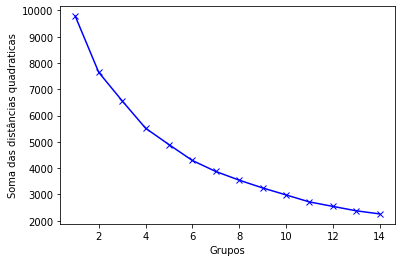

In [19]:
## Define as colunas a serem utilizadas
df_sep = df_covid_ivc_inter[['Mortalidade', 'IVC', 'hospitais', 'ocupacao1', 'ocupacao2']]

X = StandardScaler().fit_transform(df_sep)
## Para saber qual a melhor quantidade de grupos, utilizamos a técnica de calcular a soma quadratica das distâncias.
## Dividimos de 1 até 15 grupos, calculamos o erro quadratico de cada e depois plotamos o gráfico
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)
py.plot(K, sum_of_squared_distances, 'bx-')
py.xlabel('Grupos')
py.ylabel('Soma das distâncias quadraticas')
py.show()

Observando o gráfico acimo, podemos perceber que 4 foi uma quantidade que muda bastante a inclinação.
Portanto, utilizare-mos 4 grupos para realizar a divisão.

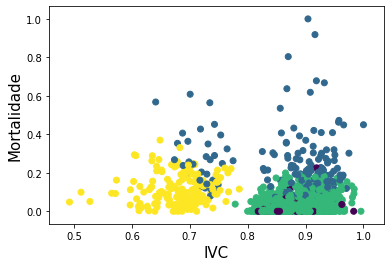

In [20]:
## Realizamos o K-means
modelo = KMeans(n_clusters=4, random_state=42)
rotulos = modelo.fit_predict(df_sep)
## Plotamos um gráfico levando em conta 2 dos 5 fatores utilizados.
py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(df_sep['IVC'], df_sep['Mortalidade'], c=rotulos)

Adiciona essa classificação no dataset

In [21]:
df_covid_ivc_inter['classificacao'] = rotulos
df_1 = df_covid_ivc_inter[df_covid_ivc_inter['classificacao'] == 0]
df_1

,UF,Nome do município,id_municipio,IVC,hospitais,ocupacao1,ocupacao2,id_municipio_6,Unnamed: 0,Município,População total,Mortalidade,POPULACAO IDOSA,POPULACAO IDOSA PERCENTUAL,classificacao
113,CE,Granjeiro,2304806,0.848775,-0.181377,0.000000,0.000000,230480,953,GRANJEIRO,0.000411,0.000000,554,0.514449,0
193,ES,Anchieta,3200409,0.904212,-0.172508,-0.056604,0.063010,320040,3101,ANCHIETA,0.002124,0.031677,2574,0.462908,0
210,ES,São José do Calçado,3204807,0.847980,-0.219076,-0.063963,-0.062465,320480,3161,SÃO JOSÉ DO CALÇADO,0.000925,0.000000,1682,0.694670,0
218,GO,Aloândia,5200506,0.865035,-0.246205,0.000000,0.000000,520050,5325,ALOÂNDIA,0.000182,0.033039,378,0.792221,0
226,GO,Araçu,5201603,0.866610,-0.170503,0.000000,0.000000,520160,5338,ARAÇU,0.000338,0.000000,597,0.674967,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,MS,Jateí,5005103,0.913532,-0.183887,0.000000,0.000000,500510,5143,JATEÍ,0.000356,0.000000,392,0.420101,0
1910,MS,Novo Horizonte do Sul,5006259,0.883931,-0.161707,-0.000604,-0.000627,500625,5154,NOVO HORIZONTE DO SUL,0.000439,0.000000,562,0.489023,0
1931,RN,Alexandria,2400505,0.818209,-0.265523,-0.001096,-0.001139,240050,1077,ALEXANDRIA,0.001200,0.000000,2004,0.637762,0
1952,RN,Severiano Melo,2413607,0.851203,-0.250904,0.000000,0.000000,241360,1222,SEVERIANO MELO,0.000511,0.000000,744,0.555999,0


 ### Primeiramente vamos identificar os outliers considerando todos os dados do dataset

Para a identificação de outliers utilizaremos o algoritmo Local Outilier Factor, que mede o desvio local da densidade de uma determinada amostra em relação a seus vizinhos. A pontuação da anomalia depende de quão isolado o objeto está em relação à vizinhança.

In [22]:
chosen_columns = ['Mortalidade', 'IVC', 'hospitais', 'ocupacao1', 'ocupacao2']
#chosen_columns = ['Mortalidade', 'IVC']

lof = LocalOutlierFactor(n_neighbors=20)
Y_lof = lof.fit_predict(df_covid_ivc_inter[chosen_columns])
outliers = Y_lof == -1
outlier_values = df_covid_ivc_inter.iloc[outliers]

Para saber o número de outliers encontrado no dataset:

In [23]:
outlier_values['Nome do município'].unique().shape[0]

84

Após plotarmos o gráfico podemos notar os outliers (em cor roxa). 

Note que a visualização não é clara pois estamos observando um conjunto de dados de 4 dimensões em um gráfico de apenas duas. 

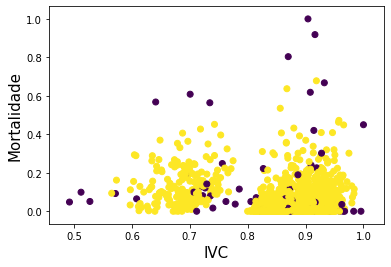

In [24]:
py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(df_sep['IVC'], df_sep['Mortalidade'], c=Y_lof)

Agora fazendo a mesma análise, porém separando os dados pela classificação gerada pelo algoritmo K-Means.

Depois de identificados os outliers, verificamos se ele se trata de um outlier negativo ou positivo (pois isso afeta a maneira como ele será usado no cálculo final).
Para tal, verificamos se ele é maior ou menor que a média de todo o conjunto. Se for maior é positivo, do contrário é negativo. 

O resultado final será uma coluna que pode assumir os seguintes valores:
- 0: não é outlier
- -1: é outlier negativo
- 1 é outlier positivo

In [25]:
def outlier_type(is_out, is_greater):
    if(is_out == 1):
        return 0
    if(is_greater):
        return 1
    return -1

In [26]:
def classify_outlier(df):
    
    mean = df['Mortalidade'].mean()
    df['eh_pos_neg'] = df['Mortalidade'].apply(lambda x: x >= mean)
    df['tipo_outlier'] = df.apply(lambda x: outlier_type(x['eh_outlier'], x['eh_pos_neg']), axis=1)
    df.drop(['eh_outlier', 'eh_pos_neg'], axis=1, inplace=True)

Primeiramente identificamos os outliers do grupo número 0.

In [27]:
# O procedimento descrito aqui é feito em todas as outras classes

# Escolhe todos os dados pertencentes ao grupo 0 e as colunas para o cálculo
class_0 = df_covid_ivc_inter.loc[df_covid_ivc_inter['classificacao'] == 0, 
                                 chosen_columns]

#Instancia o Local Outlier Factor com 80 vizinhos
lof = LocalOutlierFactor(n_neighbors=80)

#Treina o modelo para obter os outliers (-1 é outlier 1 é inliner)
Y_lof = lof.fit_predict(class_0)

# Adiciona o dado obtido na tabela de dados
class_0['eh_outlier'] = Y_lof
classify_outlier(class_0)

Plotamos o gráfico para permitir observar a distribuição dos outliers

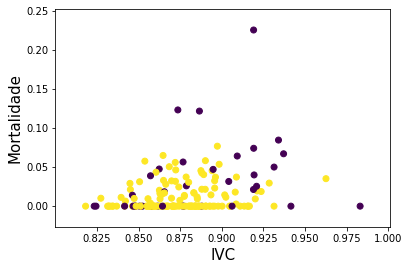

In [28]:
py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(class_0['IVC'], class_0['Mortalidade'], c=Y_lof)

Agora para o grupo número 1

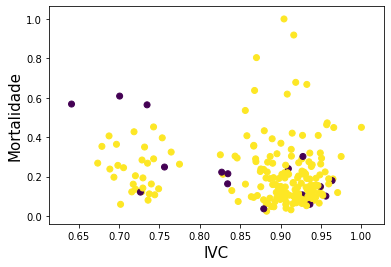

In [29]:
class_1 = df_covid_ivc_inter.loc[df_covid_ivc_inter['classificacao'] == 1, 
                                 chosen_columns]
lof = LocalOutlierFactor(n_neighbors=3)
Y_lof = lof.fit_predict(class_1)

class_1['eh_outlier'] = Y_lof
classify_outlier(class_1)

py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(class_1['IVC'], class_1['Mortalidade'], c=Y_lof)

Fazemos o memso para o grupo 2:

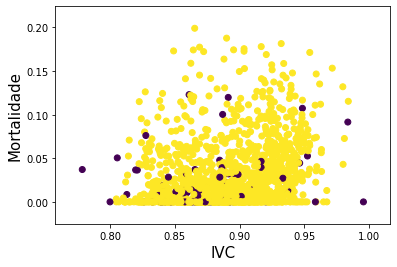

In [30]:
class_2 = df_covid_ivc_inter.loc[df_covid_ivc_inter['classificacao'] == 2, 
                                 chosen_columns]
lof = LocalOutlierFactor(n_neighbors=3)
Y_lof = lof.fit_predict(class_2)

class_2['eh_outlier'] = Y_lof
classify_outlier(class_2)

py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(class_2['IVC'], class_2['Mortalidade'], c=Y_lof)

E para o grupo 3:

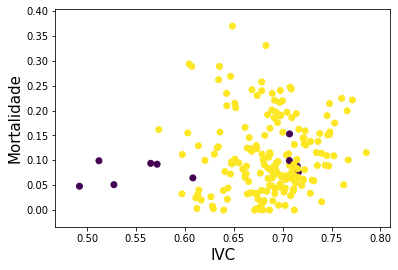

In [31]:
class_3 = df_covid_ivc_inter.loc[df_covid_ivc_inter['classificacao'] == 3, 
                                 chosen_columns]
lof = LocalOutlierFactor(n_neighbors=3)
Y_lof = lof.fit_predict(class_3)

class_3['eh_outlier'] = Y_lof
classify_outlier(class_3)

py.xlabel('IVC', fontsize=15)
py.ylabel('Mortalidade', fontsize=15)
py.scatter(class_3['IVC'], class_3['Mortalidade'], c=Y_lof)

Feito isso adicionamos o resultado no conjunto de dados com todas as colunas

In [32]:
df = pd.concat([class_0, class_1, class_2, class_3])
df = df[['tipo_outlier']]

In [33]:
df = pd.concat([df_covid_ivc_inter, df], axis=1)

### A ultima parte consiste em calcular o indice de vulnerabilidade geral das cidades

In [34]:
## Criamos uma função que ajusta o indice de mortalidade de acordo com o grupo que ele se encontra, e se o mesmo é um outlier positivo ou negativo
def valuesGroup(group, outlier):
    ## Grupo com menor risco 
    if group == 0:
        if outlier == 1:
            return 0.80
        elif outlier == -1:
            return 0.70
        return 0.75
    
    ##Grupo de maior risco
    if group == 2:
        if outlier == 1:
            return 1.30
        elif outlier == -1:
            return 1.20
        return 1.25
    
    ## Segundo grupo com menor risco
    if group == 3:
        if outlier == 1:
            return 1.0
        elif outlier == -1:
            return 0.90
        return 0.95
    
    ## Grupo de segundo maior risco
    if group == 1:
        if outlier == 1:
            return 1.15
        elif outlier == -1:
            return 1.05
        return 1.10
        

In [35]:
df

,UF,Nome do município,id_municipio,IVC,hospitais,ocupacao1,ocupacao2,id_municipio_6,Unnamed: 0,Município,População total,Mortalidade,POPULACAO IDOSA,POPULACAO IDOSA PERCENTUAL,classificacao,tipo_outlier
0,AC,Acrelândia,1200013,0.883316,-0.036590,-0.020175,0.045487,120001,52,ACRELÂNDIA,0.001114,0.015148,854,0.292786,2,0
1,AC,Assis Brasil,1200054,0.875711,-0.056157,-0.013450,0.030324,120005,53,ASSIS BRASIL,0.000540,0.000000,377,0.266888,2,0
2,AC,Cruzeiro do Sul,1200203,0.630057,-0.053565,-0.075374,0.033003,120020,57,CRUZEIRO DO SUL,0.006976,0.112322,5038,0.275848,3,0
3,AC,Rio Branco,1200401,0.735196,-0.039963,-0.125299,0.054565,120040,66,RIO BRANCO,0.029861,0.267804,21622,0.276584,1,0
4,PA,Alenquer,1500404,0.822484,-0.064845,-0.003098,-0.003219,150040,156,ALENQUER,0.004676,0.114970,4243,0.346571,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,RN,São Miguel,2412500,0.854389,-0.047247,0.000000,0.000000,241250,1208,SÃO MIGUEL,0.001969,0.000000,2811,0.545343,2,0
1951,RN,São Paulo do Potengi,2412609,0.869080,-0.079324,-0.006982,0.014896,241260,1210,SÃO PAULO DO POTENGI,0.001408,0.177475,1918,0.520393,2,0
1952,RN,Severiano Melo,2413607,0.851203,-0.250904,0.000000,0.000000,241360,1222,SEVERIANO MELO,0.000511,0.000000,744,0.555999,0,0
1953,RN,Taboleiro Grande,2413805,0.855071,-0.189081,0.000000,0.000000,241380,1224,TABOLEIRO GRANDE,0.000206,0.000000,248,0.460093,0,0


## Parte Final: Calculando o Indice de Vulnerabilidade Final

Para a crianção desse indice, utilizaremos os resultados encontrados acima
A fórmula para o calculo é:
VG = (Taxa de mortalidade * 0.3 + IVC * 0.1 - Hospitais * 0.1 + Ocupação1 * 0.05 + ocupação2*0.05 + População Idosa * 0.1 + População total * 0.25) * Valor Resultante do Grupo e outlier

#### OBS: Os sinais na fórmula podem ser invertidos para que pese positiva ou negativamente no cálculo. Como os hospitais são todos valores negativos, ele irá somar normalmente, enquanto que o IVC terá sinal negativo,

In [36]:
## Criamos a coluna para armezenar a vulnerabilidade
df['Vulnerabilidade Geral'] = 0

## Adicionamos a mortalidade, IVC, hospitais, ocupacao, populacao idosa
df['Vulnerabilidade Geral'] = df['Mortalidade'] * 0.3 - df['IVC'] * 0.1 - df['hospitais']*0.1 + df['ocupacao1']*0.05 + df['ocupacao2']*0.05 + df['POPULACAO IDOSA PERCENTUAL']*0.1


##Populacao total
df['Vulnerabilidade Geral'] = df['Vulnerabilidade Geral'] + df['População total']*0.25

## Divisao pelos grupos e pelos outliers
df['Vulnerabilidade Geral'] = df['Vulnerabilidade Geral']*df.apply(lambda x: valuesGroup(x['classificacao'], x['tipo_outlier']), axis=1)


df = df.sort_values('Vulnerabilidade Geral')

Realizando uma comparação com o IVC

C:\Users\luank\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002270A22A908>,
      dtype=object)

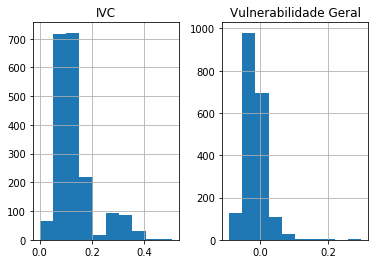

In [37]:
df2 = df[['UF', 'Nome do município', 'Vulnerabilidade Geral', 'IVC']]
a = df2[['Vulnerabilidade Geral', 'IVC']]
a['IVC'] = 1 - a['IVC']
a.hist()

In [38]:
a['Vulnerabilidade Geral'].corr(a['IVC'])

0.3778930163923491

In [40]:
dfa = df[['UF', 'Nome do município', 'Vulnerabilidade Geral']]
dfa = dfa.sort_values('Vulnerabilidade Geral', ascending=False)
dfa.head(10)

,UF,Nome do município,Vulnerabilidade Geral
791,RJ,Rio Claro,0.298157
1334,SP,Pariquera-Açu,0.294387
1410,SP,São Paulo,0.272736
619,PE,Trindade,0.217289
670,PR,Campo Largo,0.198541
792,RJ,Rio de Janeiro,0.187121
669,PR,Campina Grande do Sul,0.178680
1458,TO,Augustinópolis,0.177420
181,CE,Sobral,0.176774
514,PB,Santa Rita,0.169902


In [41]:
dfa.tail(10)

,UF,Nome do município,Vulnerabilidade Geral
446,MT,Colniza,-0.075790
37,PA,Santana do Araguaia,-0.077214
737,PR,São José dos Pinhais,-0.078344
1908,MS,Nova Alvorada do Sul,-0.078405
371,GO,Santo Antônio do Descoberto,-0.079316
1916,MS,Ribas do Rio Pardo,-0.079481
430,MT,Alto Taquari,-0.080525
1861,MS,Água Clara,-0.082440
468,MT,Nova Maringá,-0.084469
258,GO,Chapadão do Céu,-0.091174
